<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/BookNLP_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# <img src="https://www.gutenberg.org/gutenberg/pg-logo-129x80.png" width=50 height=50>   <font color='Orange'>Book NLP 5 - <br> <b>Text</b>  to <b>Image</b> with Stable Diffusion</font>





---





In [60]:
#@title Imports

from google.colab import files
import pandas as pd
#import urllib.request
import os.path
import re

from google.colab.data_table import DataTable
DataTable.max_columns = 50

import numpy as np
import cv2
import os
import requests
import json

style_list =["Colorful cartoon drawing style", "anime art style", "Line drawing", "Coloring book page", "Salvador Dali", "A digital painting with an anime-inspired art style",
    "Detailed Renaissance style", "Surrealist painting", "Impressionist", "Abstract painting", "Pop Art painting", "Baroque-style", "Cubist painting", "Romantic painting",
    "Art Nouveau painting", "Gothic painting", "Macro photography", "Aerial photography", "Underwater photography", "Vintage-style travel photography", "Long-exposure night photography",
    "Documentary-style photography", "Photography with a shallow depth of field and soft lighting", "Cyberpunk with neon signs", "Fantasy illustration",
    "Digital painting", "Concept art", "Isometric digital art" , "Digital illustration in manga style", "Minimalistic digital artwork",
    "Sci-fi digital painting", "Steampunk digital art","Yamato-e","Kanō school","Gongbi","Shuimo","Literary painting",
    "Caricature drawing",  "Figure drawing", "Gesture drawing", "Scratchboard drawing", "Perspective drawing",
    "Photorealism", "Pointillism", "Scientific illustrations", "Silhouette drawing" , "Sketch drawing", "Technical drawing",
    "Vincent van Gogh", "Gustave Klimt", "M.C. Escher", "Claude Monet", "René Magritte", "Pablo Picasso",
    "Leonardo da Vinci", "Edvard Munch", "Andy Warhol",  "Pixel art"]





---

#  <font color='Blue'> 1. Mount the drive</font>  



In [61]:
from google.colab import drive

import os
if os.path.isdir('/content/drive/MyDrive'):
    print('Google Drive is mounted.')
else:
    drive.mount('/content/drive')


Google Drive is mounted.



---

#  <font color='Blue'> 2. Get prompts</font>  

In [62]:
style = style_list[0]
negative_prompt='distorted, ugly, deformed, disfigured, poor details' # grayscale,


## There are several ways to write a prompt.

>The first is to simply modify the JSON snippet below.

>Another way is to simply take this Prompt [Example_for_prompt](https://raw.githubusercontent.com/aalgirdas/novel-semantic-parsing/refs/heads/main/data/promt_for_scene_analysis.txt
), then add a TEXT part to it, then submit it to ChatGPT or Gemini and then replace the received response in place the JSON fragment below.

> The third way is to clean the JSON fragment and submit a .json file from the Internet instead.



In [63]:
prompt_response_json_text = ""

In [64]:
#@title If the prompt_response_json_text variable is an empty string then the json file from the Internet must be submitted

if len(prompt_response_json_text)==0:
  book_code = '244' # 84  244 2701 2852 42671
  url = "https://raw.githubusercontent.com/aalgirdas/novel-semantic-parsing/refs/heads/main/data/gpt4_scene_info_"+book_code+".json"
  response = requests.get(url)
  prompt_response_json_text = response.text
else:
  prompt_response_json_text = '{"1":'+prompt_response_json_text+'}'

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
data = json.loads(prompt_response_json_text)
print("JSON data:", data)


JSON data: {'9-27': [{'scene_title': 'Meeting Stamford at the Criterion Bar', 'description': "Dr. Watson, after deciding to change his living arrangements due to financial constraints, encounters an old acquaintance, Stamford, at the Criterion Bar in London. They recognize each other and decide to have lunch together, discussing Watson's recent hardships and his current search for affordable lodgings.", 'scene_type': 'INT', 'scene_date': '1878', 'location': 'Criterion Bar, London', 'time_of_day': 'NOON', 'scene_transition_type': 'CUT TO', 'characters': ['Dr. Watson', 'Stamford'], 'objects': ['bar', 'wine-glass'], 'text_phrases': ['standing at the Criterion Bar', 'tapped me on the shoulder', 'turning round I recognized young Stamford', 'asked him to lunch with me at the Holborn', 'we started off together in a hansom', 'rattled through the crowded London streets']}, {'scene_title': 'Conversation about Lodgings', 'description': "During lunch at the Holborn, Watson and Stamford discuss Wat

In [67]:
number_of_prompts = 10 #+1000

scene_nr = 1
prompts = []
scene_dates = []
scene_locations = []
scene_objects = []
for key, value in data.items():
  for item in value:
    print(f"{scene_nr:>5} {item.get('description')}")
    prompts.append(item.get('description'))
    scene_dates.append(item.get('scene_date'))
    scene_locations.append(item.get('location'))
    scene_objects.append(item.get('objects'))
    scene_nr += 1

  if scene_nr > number_of_prompts:
    break

    1 Dr. Watson, after deciding to change his living arrangements due to financial constraints, encounters an old acquaintance, Stamford, at the Criterion Bar in London. They recognize each other and decide to have lunch together, discussing Watson's recent hardships and his current search for affordable lodgings.
    2 During lunch at the Holborn, Watson and Stamford discuss Watson's need for new lodgings. Stamford mentions another man, Sherlock Holmes, who is also looking for a roommate to share the expenses of some nice rooms he found.
    3 Dr. Watson meets Sherlock Holmes for the first time in a chemical laboratory where Holmes is excitedly sharing his discovery of a new reagent for blood detection.
    4 Sherlock Holmes and Dr. John Watson discuss their personal habits and peculiarities as they consider becoming roommates.
    5 Sherlock Holmes and Dr. John Watson finalize their decision to share rooms at Baker Street after discussing their habits and ensuring they are compatibl

---

#  <font color='Blue'>🔗 Diffusers</font>  

In [68]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy peft

In [69]:
%%capture
import mediapy as media
import random
import sys
import torch

from diffusers import DiffusionPipeline, TCDScheduler
from huggingface_hub import hf_hub_download

# Choose either 8 or 12 steps:
num_inference_steps = 12

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "ByteDance/Hyper-SD"
plural = "s" if num_inference_steps > 1 else ""
ckpt_name = f"Hyper-SDXL-{num_inference_steps}step{plural}-CFG-lora.safetensors"
device = "cuda"

pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16, variant="fp16").to(device)
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))
pipe.fuse_lora()
pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

0    1878. Location is Criterion Bar, London. Objects: bar, wine-glass. Colorful cartoon drawing style. Dr. Watson, after deciding to change his living arrangements due to financial constraints, encounters an old acquaintance, Stamford, at the Criterion Bar in London. They recognize each other and decide to have lunch together, discussing Watson's recent hardships and his current search for affordable lodgings. 


  0%|          | 0/12 [00:00<?, ?it/s]

1    1878. Location is Holborn Restaurant, London. Objects: lunch table, wine-glass. Colorful cartoon drawing style. During lunch at the Holborn, Watson and Stamford discuss Watson's need for new lodgings. Stamford mentions another man, Sherlock Holmes, who is also looking for a roommate to share the expenses of some nice rooms he found. 


  0%|          | 0/12 [00:00<?, ?it/s]

2    1881. Location is Chemical laboratory in a hospital. Objects: test-tube, Bunsen lamps, chemical pipette, bottles, tables, retorts, test-tubes. Colorful cartoon drawing style. Dr. Watson meets Sherlock Holmes for the first time in a chemical laboratory where Holmes is excitedly sharing his discovery of a new reagent for blood detection. 


  0%|          | 0/12 [00:00<?, ?it/s]

3    1881. Location is Stamford's laboratory. Objects: three-legged stool, chemicals, plaster. Colorful cartoon drawing style. Sherlock Holmes and Dr. John Watson discuss their personal habits and peculiarities as they consider becoming roommates. 


  0%|          | 0/12 [00:00<?, ?it/s]

4    1881. Location is Stamford's laboratory. Objects: chemicals, violin. Colorful cartoon drawing style. Sherlock Holmes and Dr. John Watson finalize their decision to share rooms at Baker Street after discussing their habits and ensuring they are compatible roommates. 


  0%|          | 0/12 [00:00<?, ?it/s]

5    1881. Location is 221B Baker Street. Objects: boxes, portmanteaus, furniture. Colorful cartoon drawing style. Sherlock Holmes and Dr. John Watson move their belongings into their new shared apartment at 221B Baker Street. 


  0%|          | 0/12 [00:00<?, ?it/s]

6    1881. Location is Narrator's living room. Objects: Armchair, Fiddle. Colorful cartoon drawing style. The narrator reflects on his curiosity about his mysterious companion, leading to a conversation where the companion reveals his selective knowledge acquisition philosophy. 


  0%|          | 0/12 [00:00<?, ?it/s]

7    1881. Location is Narrator's study. Objects: Pencil, Paper, Fireplace. Colorful cartoon drawing style. The narrator lists out the areas of knowledge and ignorance of his companion, Sherlock Holmes, reflecting on the peculiarities of his expertise. 


  0%|          | 0/12 [00:00<?, ?it/s]

8    1881. Location is Holmes's living room. Objects: Violin, Armchair. Colorful cartoon drawing style. Sherlock Holmes plays the violin in a reflective and sometimes whimsical manner, showcasing his mood through music. 


  0%|          | 0/12 [00:00<?, ?it/s]

9    1881. Location is Sherlock Holmes' Sitting Room. Objects: Sitting room furniture, Bedroom door. Colorful cartoon drawing style. Sherlock Holmes receives various visitors in his sitting room, ranging from Mr. Lestrade to a fashionably dressed young girl, a seedy looking old man, and others, indicating the diverse nature of his clientele. 


  0%|          | 0/12 [00:00<?, ?it/s]

10    1881. Location is Sherlock Holmes' Residence, Dining Area. Objects: Breakfast table, Magazine, Egg spoon. Colorful cartoon drawing style. Dr. Watson finds Sherlock Holmes still at breakfast, leading to a discussion about an article Holmes wrote on deduction, which Watson initially criticizes. 


  0%|          | 0/12 [00:00<?, ?it/s]

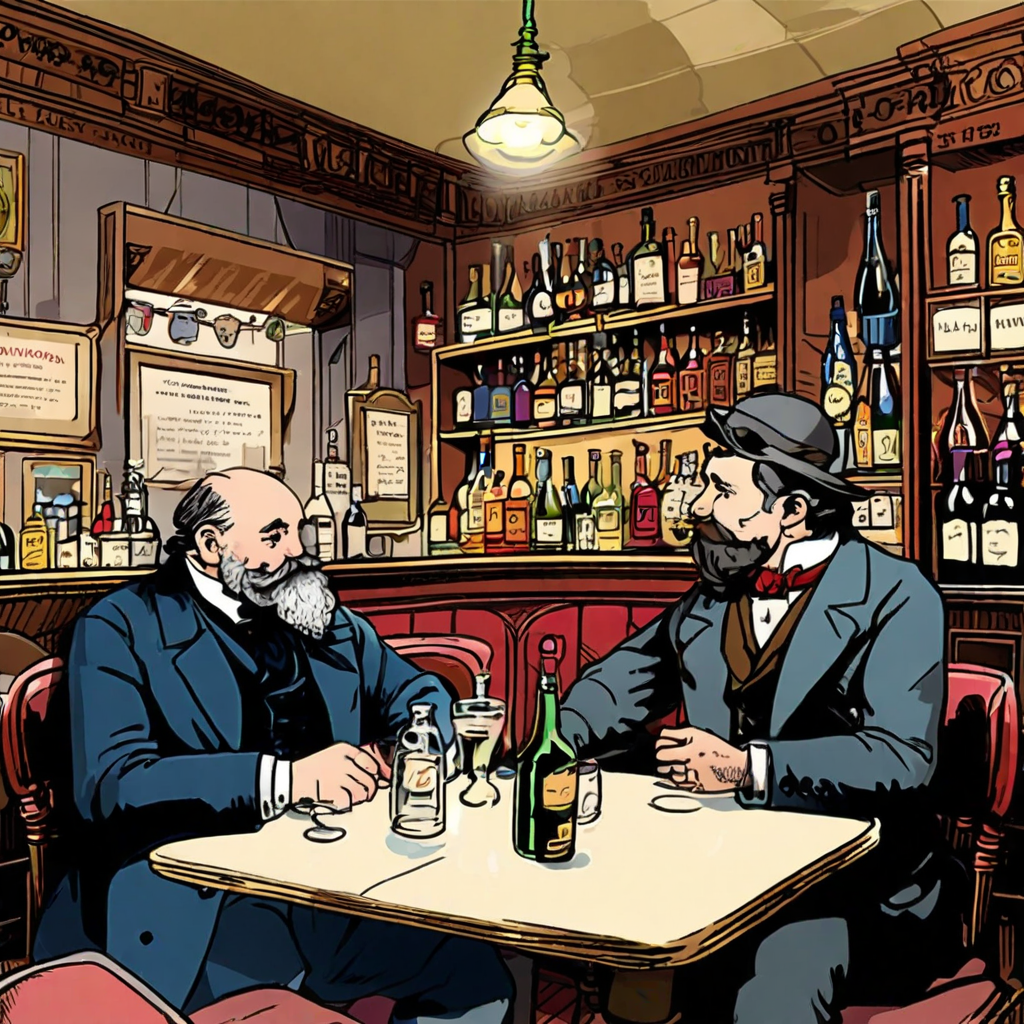

In [70]:
seed = random.randint(0, sys.maxsize)
guidance_scale = 5.0 ## Pick a value between 5.0 and 8.0:
eta = 0.1 # # Decrease eta (min: 0, max: 1.0) to get more details with multi-step inference:


all_images_list = []
for image_nr, prompt in enumerate(prompts):
        #images = model.text_to_image(style  + ' ' +prompt, batch_size=1)

        if 'scene_dates' in globals():
          prompt = scene_dates[image_nr]  + ". Location is "+scene_locations[image_nr]+". Objects: " + (", ".join(scene_objects[image_nr]))+ ". " + style + ". "  + prompt
        print(f'{image_nr}    {prompt} ')
        images = pipe( prompt = prompt,  num_inference_steps = num_inference_steps ,  guidance_scale = guidance_scale,   eta = eta,    generator = torch.Generator(device).manual_seed(seed),  negative_prompt=negative_prompt   ).images
        image_info_tuple = (image_nr, prompt, images[0]  )
        all_images_list.append(image_info_tuple)
        #break

all_images_list[0][2]

In [71]:

image_list = [np.array(img[2]) for img in all_images_list]

In [72]:


def save_images(image_list, directory):

    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, image in enumerate(image_list):
        filename = f"image_{i}.jpg"  # Adjust the filename format as needed
        filepath = os.path.join(directory, filename)
        cv2.imwrite(filepath, image)


directory = "saved_images"

save_images(image_list, directory)

!zip -r saved_images.zip saved_images
!cp saved_images.zip /content/drive/MyDrive/saved_images.zip

updating: saved_images/ (stored 0%)
updating: saved_images/image_0.jpg (deflated 1%)
  adding: saved_images/image_9.jpg (deflated 0%)
  adding: saved_images/image_3.jpg (deflated 0%)
  adding: saved_images/image_4.jpg (deflated 0%)
  adding: saved_images/image_7.jpg (deflated 1%)
  adding: saved_images/image_10.jpg (deflated 0%)
  adding: saved_images/image_2.jpg (deflated 1%)
  adding: saved_images/image_6.jpg (deflated 1%)
  adding: saved_images/image_5.jpg (deflated 0%)
  adding: saved_images/image_1.jpg (deflated 1%)
  adding: saved_images/image_8.jpg (deflated 0%)



---

#  <font color='Blue'>🎬 Let's try to put all the images into a video file with audio track </font>  

In [73]:
!pip install gTTS -q

In [75]:
from gtts import gTTS

mp3_list = []
for image_nr, prompt in enumerate(prompts):
  mytext = prompt
  myobj = gTTS(text=mytext, lang='en', slow=False, tld='co.uk')  # https://gtts.readthedocs.io/en/latest/module.html#gtts.tts.gTTS
  myobj.save("welcome"+str(image_nr)+".mp3")
  mp3_list.append("welcome"+str(image_nr)+".mp3")
  print(f'{image_nr} ', end='')



0 1 2 3 4 5 6 7 8 9 10 

In [76]:
!pip install -q moviepy pillow

In [77]:
import numpy as np
from PIL import Image
from moviepy.editor import ImageSequenceClip, AudioFileClip, concatenate_videoclips

frames = [np.array(img) for img in image_list] # images to numpy arrays

video_clips = []
for i, frame in enumerate(frames):
    audio_clip = AudioFileClip(mp3_list[i])

    ##img_clip = ImageSequenceClip([frame], fps=1)  # 1 frame per second
    img_clip = ImageSequenceClip([frame], durations=[audio_clip.duration])  # 1 frame per second

    #img_clip = img_clip.set_duration(audio_clip.duration)  # Set the duration of the image clip to match the audio clip

    img_clip = img_clip.set_audio(audio_clip)

    video_clips.append(img_clip)

final_clip = concatenate_videoclips(video_clips)

final_clip.write_videofile("output_video_with_audio.mp4", codec="libx264",fps=1)

Moviepy - Building video output_video_with_audio.mp4.
MoviePy - Writing audio in output_video_with_audioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_video_with_audio.mp4



Moviepy - Done !
Moviepy - video ready output_video_with_audio.mp4
